# Library

In [1]:
try:
    import json 
    import os
    import random
    from math import sin, cos, sqrt, atan2, radians

    import networkx as nx
    from networkx.drawing.nx_agraph import graphviz_layout, pygraphviz_layout

    import powerlaw
    from empiricaldist import Cdf

    import pandas as pd
    import numpy as np

    import seaborn as sns
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import plotly.graph_objects as go
    import plotly.express as px
    import kaleido
    
    import folium
    from folium import *
    from folium import plugins

    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Line3DCollection

    import dataframe_image as dfi
    
except ModuleNotFoundError as er:
    print(er)
    %pip install --upgrade dataframe_image
    %pip install --upgrade pip
    %pip install --upgrade wheel
    %pip install --upgrade folium
    %pip install --upgrade pandas
    %pip install --upgrade networkx
    %pip install --upgrade plotly.express
    %pip install --upgrade numpy
    %pip install powerlaw
    %pip install empiricaldist
    %pip install pexpect
    %pip install pickleshare
    %pip install python-igraph
    %pip install simplegeneric
    %pip install traitlets
    %pip install wsgiref
    %pip install mpl_toolkits
    

# Class used in the analysis

In [3]:
class ParisTransportation:
    """
    Main class
    """

    def __init__(self):
        self.jsonfile = f"geojson{os.sep}multigraph.geojson"
        self.graphmlfile = f"multigraph.graphml"
        self.gmlfile = f"multigraph.gml"

    def clean_data(self):
        if not os.path.exists("gml"):
            os.makedirs("gml")
        if not os.path.exists("_img"):
            os.makedirs("_img")
        if not os.path.exists("maps"):
            os.makedirs("maps")
        if not os.path.exists("csv"):
            os.makedirs("csv")

        #G = nx.DiGraph() #total
        H = nx.DiGraph() #road
        Q = nx.Graph() #metro
        I = nx.Graph() #train
        O = nx.Graph() #tram

        df_data = []
        with open(self.jsonfile, 'r') as jsfile:
            for line in jsfile:
                jsentry = json.loads(line)
                df_data.append(jsentry)
                if jsentry['properties']['type'] == "edge":
                    if 'direction' in jsentry['properties']:
                        if jsentry['properties']['direction'] == "Double sens":
                            direction = "TwoWay"
                        elif (jsentry['properties']['direction'] == "Sens inverse" 
                            or jsentry['properties']['direction'] == "Sens unique"):
                            direction = "OneWay"
                    else:
                        direction = "TwoWay"

                    ID = jsentry['_id']['$oid']
                    Source = jsentry['properties']['mongo_org_id']
                    Target = jsentry['properties']['mongo_dest_id']
                    Layer = jsentry['properties']['layer']
                    Coordinates = jsentry['geometry']['coordinates']
                    Direction = direction

                    try:
                        Length = jsentry['properties']['length']
                    except:
                        Length = None
                    try:
                        Name = jsentry['properties']['name']
                        if Name.startswith("54"):
                            Name = None
                    except:
                        Name = None

                    degreeDual = jsentry['properties']['degreeDual']

                    if Layer == "road":
                        if Direction == "TwoWay":
                            H.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual, layer=Layer)
                            #H.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual, layer=Layer)
                        elif Direction == "OneWay":
                            H.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual, layer=Layer)
                        H.nodes[Source]['lat'] = Coordinates[0][1]
                        H.nodes[Source]['lon'] = Coordinates[0][0]
                        H.nodes[Source]['pos'] = f"{H.nodes[Source]['lat']},{H.nodes[Source]['lon']}"
                        H.nodes[Source]['layer'] = Layer

                        H.nodes[Target]['lat'] = Coordinates[1][1]
                        H.nodes[Target]['lon'] = Coordinates[1][0]
                        H.nodes[Target]['pos'] = f"{H.nodes[Target]['lat']},{H.nodes[Target]['lon']}"
                        H.nodes[Target]['layer'] = Layer

                    elif Layer == "metro":
                        Q.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #Q.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        Q.nodes[Source]['lat'] = Coordinates[0][1]
                        Q.nodes[Source]['lon'] = Coordinates[0][0]
                        Q.nodes[Source]['pos'] = f"{Q.nodes[Source]['lat']},{Q.nodes[Source]['lon']}"
                        Q.nodes[Source]['layer'] = Layer

                        Q.nodes[Target]['lat'] = Coordinates[1][1]
                        Q.nodes[Target]['lon'] = Coordinates[1][0]
                        Q.nodes[Target]['pos'] = f"{Q.nodes[Target]['lat']},{Q.nodes[Target]['lon']}"
                        Q.nodes[Target]['layer'] = Layer

                    elif Layer == "train":
                        I.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #I.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        I.nodes[Source]['lat'] = Coordinates[0][1]
                        I.nodes[Source]['lon'] = Coordinates[0][0]
                        I.nodes[Source]['pos'] = f"{I.nodes[Source]['lat']},{I.nodes[Source]['lon']}"
                        I.nodes[Source]['layer'] = Layer

                        I.nodes[Target]['lat'] = Coordinates[1][1]
                        I.nodes[Target]['lon'] = Coordinates[1][0]
                        I.nodes[Target]['pos'] = f"{I.nodes[Target]['lat']},{I.nodes[Target]['lon']}"
                        I.nodes[Target]['layer'] = Layer

                    elif Layer == "tram":
                        O.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #O.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        O.nodes[Source]['lat'] = Coordinates[0][1]
                        O.nodes[Source]['lon'] = Coordinates[0][0]
                        O.nodes[Source]['pos'] = f"{O.nodes[Source]['lat']},{O.nodes[Source]['lon']}"
                        O.nodes[Source]['layer'] = Layer

                        O.nodes[Target]['lat'] = Coordinates[1][1]
                        O.nodes[Target]['lon'] = Coordinates[1][0]
                        O.nodes[Target]['pos'] = f"{O.nodes[Target]['lat']},{O.nodes[Target]['lon']}"
                        O.nodes[Target]['layer'] = Layer

                    else:
                        continue
                else:
                    continue

        #nx.write_graphml(H, f"gml{os.sep}road_{self.graphmlfile}")
        #nx.write_graphml(H,  f"gml{os.sep}road_{self.gmlfile}")
        #nx.write_graphml(Q, f"gml{os.sep}metro_{self.graphmlfile}")
        #nx.write_graphml(Q,  f"gml{os.sep}metro_{self.gmlfile}")
        #nx.write_graphml(I, f"gml{os.sep}train_{self.graphmlfile}")
        #nx.write_graphml(I,  f"gml{os.sep}train_{self.gmlfile}")
        #nx.write_graphml(O, f"gml{os.sep}tram_{self.graphmlfile}")
        #nx.write_graphml(O,  f"gml{os.sep}tram_{self.gmlfile}")

        return(H, Q, I, O, df_data)


    def geoJSON(self):
        df = pd.read_json(f'geojson{os.sep}multigraph.geojson', lines=True)
        id = pd.json_normalize(df["_id"])
        id = id.rename(columns={"$oid": "ID"})

        geom = pd.json_normalize(df["geometry"])
        geom = geom.rename(columns={"type": "LP"})

        prop = pd.json_normalize(df["properties"])

        new_df = pd.concat([id, geom, prop], axis=1)
        return(new_df)
    
    class MapMaker:
        def __init__(self, df):
            self.df = df
            self.only_point = df.loc[df['LP'] == "Point"]
            self.points = [(t[1], t[0]) for t in self.only_point.coordinates.tolist()]
            self.center = (48.85654066902656, 2.349154275836)
            self.canvas = True,
            self.bounds = False,
            self.filename = f"maps{os.sep}france.html"
            self.layerColor = {
                "road": "green",
                "train": "blue",
                "metro": "gray",
                "tram": "purple"
            }

        @staticmethod
        def calculate_distance(lon1, lat1, lon2, lat2, R=6357):
            lat1 = radians(lat1)
            lat2 = radians(lat2)
            lon1 = radians(lon1)
            lon2 = radians(lon2)

            dlon = lon2 - lon1
            dlat = lat2 - lat1

            a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))

            distance = R * c
            return distance
        
        def create_map(self):
            if not os.path.exists(self.filename):
                m = Map(location=[self.center[0], self.center[1]], 
                    tiles="CartoDB positron", 
                    zoom_start=9,
                    zoom_control=True, 
                    prefer_canvas=self.canvas)

                layers = self.only_point.layer.unique().tolist()

                fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
                plugins.MousePosition(position='topright', separator=' | ', prefix="Mouse:", lng_formatter=fmtr, lat_formatter=fmtr).add_to(m)

                plugins.Geocoder(collapsed=False, position='topright', add_marker=True).add_to(m)

                plugins.Draw(
                    export=True,
                    filename='my_data.geojson',
                    position='topleft',
                    draw_options={'polyline': {'allowIntersection': False}},
                    edit_options={'poly': {'allowIntersection': False}}
                ).add_to(m)

                fg = FeatureGroup(control=False, show=False)
                m.add_child(fg)

                f1 = plugins.FeatureGroupSubGroup(fg, layers[0].capitalize())
                m.add_child(f1)

                f2 = plugins.FeatureGroupSubGroup(fg, layers[1].capitalize())
                m.add_child(f2)

                f3 = plugins.FeatureGroupSubGroup(fg, layers[2].capitalize())
                m.add_child(f3)

                f4 = plugins.FeatureGroupSubGroup(fg, layers[3].capitalize())
                m.add_child(f4)

                m.add_child(plugins.HeatMap(
                    self.points, 
                    name="HeatMap",
                    radius=15,
                    show=False)
                    )

                i = 0
                layerTypes = self.only_point.layer.tolist()

                for lat, lon in self.points:

                    distance = self.calculate_distance(lon, lat, self.center[1], self.center[0])
                    radiusDistance = distance

                    if int(distance) > 0:
                        distance = int(distance)
                        distance = f"{distance} km"
                    else:
                        distance = distance * 1000
                        distance = int(distance)
                        distance = f"{distance} mt"

                    circle = Circle(
                        location=(lat, lon),
                        tooltip=f"<strong>Type:</strong> {layerTypes[i]}<br><strong>Center distance:</strong> {distance}",
                        radius=sqrt(radiusDistance * 1000),
                        popup=f"<strong>Type:</strong> {layerTypes[i]}<br><strong>Lat:</strong> {lat}<br><strong>Long:</strong> {lon}<br><strong>Center distance:</strong> {distance}",
                        color=self.layerColor.get(layerTypes[i]),
                        fill=False,
                        fill_color=self.layerColor.get(layerTypes[i])
                    )
                    
                    if layerTypes[i] == layers[0]:
                        f1.add_child(circle)
                    elif layerTypes[i] == layers[1]:
                        f2.add_child(circle)
                    elif layerTypes[i] == layers[2]:
                        f3.add_child(circle)
                    elif layerTypes[i] == layers[3]:
                        f4.add_child(circle)

                    i +=1

                paris = Circle(
                    location=(self.center[0], self.center[1]),
                    tooltip="Center",
                    popup="",
                    radius=80,
                    color="crimson",
                    fill=True,
                    fill_color="crimson"
                )
                paris.add_to(fg)

                
                plugins.LocateControl().add_to(m)
                plugins.MiniMap(position='bottomright').add_to(m)
                
                
                plugins.Fullscreen(position='topleft', title='Full Screen', title_cancel='Exit Full Screen', force_separate_button=True).add_to(m)
                plugins.MeasureControl(position='bottomleft', primary_length_unit='kilometers', secondary_length_unit='meters').add_to(m)

                TileLayer('Stamen Terrain').add_to(m)
                TileLayer('Stamen Toner').add_to(m)
                TileLayer('Stamen Water Color').add_to(m)
                TileLayer('cartodbpositron').add_to(m)
                TileLayer('cartodbdark_matter').add_to(m)

                LayerControl().add_to(m)
                m.save(self.filename)

In [4]:
class TransportMap:
    def __init__(self, metro_layer, train_layer, tram_layer):
        self.metro_layer = metro_layer
        self.train_layer = train_layer
        self.tram_layer = tram_layer
    
    @staticmethod
    def edges2df(G, id_indexed: bool = True):
        df = pd.DataFrame(dict(G.edges()).items(),columns = ['Source-Target', 'Values'])
        df = pd.concat([df.drop(['Source-Target'], axis=1), df['Source-Target'].apply(pd.Series)], axis=1).rename(columns={0: "source", 1: "target"})
        df = pd.concat([df.drop(['Values'], axis=1), df['Values'].apply(pd.Series)], axis=1)
        if id_indexed is True:
            df = df.set_index('id')
        return(df) 
    
    def drawMap(self, line_width: int):
        fig = Figure(width=1000,height=500)
        m = folium.Map(location=[48.857001, 2.341848], zoom_start=9.5, tiles="CartoDBpositron")
        fig.add_child(m)

        fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
        folium.plugins.MousePosition(position='topright', separator=' | ', prefix="Mouse:", lng_formatter=fmtr, lat_formatter=fmtr).add_to(m)
        folium.plugins.Geocoder(collapsed=False, position='topright', add_marker=True).add_to(m)

        folium.plugins.Draw(
            export=True,
            filename='my_data.geojson',
            position='topleft',
            draw_options={'polyline': {'allowIntersection': False}},
            edit_options={'poly': {'allowIntersection': False}}
        ).add_to(m)

        f1=folium.FeatureGroup("Tram")
        f1.add_to(m)
        f2=folium.FeatureGroup("Metro")
        f2.add_to(m)
        f3=folium.FeatureGroup("Train")
        f3.add_to(m)

        folium.TileLayer('Stamen Terrain').add_to(m)
        folium.TileLayer('Stamen Toner').add_to(m)
        folium.TileLayer('Stamen Water Color').add_to(m)
        folium.TileLayer('cartodbpositron').add_to(m)
        folium.TileLayer('cartodbdark_matter').add_to(m)
        folium.LayerControl().add_to(m)

        train_df = self.edges2df(self.train_layer)
        metro_df = self.edges2df(self.metro_layer)
        tram_df = self.edges2df(self.tram_layer)

        for segment, line_name in zip(train_df.coord, train_df.name):
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup=f'<b>Train Network {line_name}</b>',
                tooltip='Train',
                color='green',
                weight=line_width).add_to(f3)

        for segment in metro_df.coord:
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup='<b>Metro Network</b>',
                tooltip='Metro',
                color='blue',
                weight=line_width).add_to(f2)

        for segment in tram_df.coord:
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup='<b>Tram Network</b>',
                tooltip='Tram',
                color='orange',
                weight=line_width).add_to(f1)
        
        
        folium.plugins.LocateControl().add_to(m)
        folium.plugins.MiniMap(position='bottomright').add_to(m)
    
        folium.plugins.Fullscreen(position='topleft', title='Full Screen', title_cancel='Exit Full Screen', force_separate_button=True).add_to(m)
        folium.plugins.MeasureControl(position='bottomleft', primary_length_unit='kilometers', secondary_length_unit='meters').add_to(m)
        m.save(f'maps{os.sep}france_transport.html')
        return(m)
    

In [5]:
class Multiplex():
    def __init__(self):
        self.layers = []
        self.G = nx.Graph()
        self.crosslayers = pd.read_csv(f"csv{os.sep}labeled_crosslayers.csv", encoding="utf-8",sep=";")

    @staticmethod
    def haversine(lon1, lat1, lon2, lat2, R=6357):
        """
        Compute distance between two points
        """
        lat1 = radians(lat1)
        lat2 = radians(lat2)
        lon1 = radians(lon1)
        lon2 = radians(lon2)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        return distance

    @staticmethod
    def centorid(pos1: tuple, pos2: tuple) -> tuple:
            """
            pos1: tuple (lat, lon)
            pos2: tuple (lat, lon)

            return: (avg_lat,avg_lon)
            """
            avg_lat = (pos1[0]+pos2[0])/2
            avg_lon = (pos1[1]+pos2[1])/2
            return (avg_lat, avg_lon)

    def spatial_join(self, layer1, layer2, distance_threshold: int, transfer_speed: float = 5, base_cost: int = 0):
        """
        transfer_speed (float) -> walking speed to reach destination
        base_cost (int) -> mean time waiting the transport vehicle
        """
        if layer1<=layer2:
            transfer_layer_name = layer1 + '--' + layer2
        else:
            transfer_layer_name = layer2 + '--' + layer1
        self.layers.append(transfer_layer_name)

        layer1_copy = self.layers_as_subgraph([layer1])	
        layer2_copy = self.layers_as_subgraph([layer2])

        edges_added = 0
        for n in layer1_copy.nodes:
            for m in layer2_copy.nodes:
                dist = int(self.haversine(layer1_copy.nodes[n]['lon'], layer1_copy.nodes[n]['lat'], layer2_copy.nodes[m]['lon'], layer2_copy.nodes[m]['lat'])*1000)
                if dist <= distance_threshold:
                    self.G.add_edge(n, m, 
                            layer = transfer_layer_name,
                            dist_km = dist/1000, 
                            weight = (dist/1000) / transfer_speed + base_cost)

                    edges_added += 1

        print (f'Added {str(edges_added)} transfers between {layer1} and {layer2}')

    def add_crosslayer(self, layer1, layer2):
        df = self.crosslayers

        if layer1<=layer2:
            transfer_layer_name = layer1 + '--' + layer2
        else:
            transfer_layer_name = layer2 + '--' + layer1
        self.layers.append(transfer_layer_name)

        layer1_copy = self.layers_as_subgraph([layer1])	
        layer2_copy = self.layers_as_subgraph([layer2])

        edges_added = 0
        for n,attr1 in layer1_copy.nodes.items():
            for m,attr2 in layer2_copy.nodes.items():
                if len(df[(df.mongo_org_id==attr1['name']) & (df.mongo_dest_id==attr2['name'])]) != 0:
                    self.G.add_edge(n, m, layer = transfer_layer_name)

                    edges_added += 1

        print (f'Added {str(edges_added)} transfers between {layer1} and {layer2}')

    
    def add_layers(self, layer_dict):
        '''
        Add layers from a dict of networkx graphs.
        
        args:
            layer_dict: (dict) a dict of layer names and graphs, e.g. {'metro' : metro, 'street' : street}
        '''
        for layer in layer_dict:
            if layer in self.layers: 
                print(layer_dict[layer])
                print("ERROR: The layer" + layer + "is already defined in the multiplex, did not overwrite")
            
            else:
                self.layers.append(layer)
                #nx.set_node_attributes(layer_dict[layer], 'layer', layer)
                #nx.set_edge_attributes(layer_dict[layer], 'layer', layer)
                self.G = nx.disjoint_union(self.G, layer_dict[layer])
                #for n, attr in layer_dict[layer].nodes.items():
                #    nx.set_node_attributes(layer_dict[layer], n, 'name')
                self.label_nodes()
                
    def label_nodes(self, old_label = 'old_label'):
        """
        Summary:
            Generate new labels for the nodes of the multiplex. 
        
        Args:
            old_label (str, optional): Name of attribute under which to save the old labels
        
        Returns:
            None 
        """
        self.G = nx.convert_node_labels_to_integers(self.G, label_attribute = old_label)
        new_labels = {n : self.G.nodes[n]['layer'] + '_' + str(n) for n in self.G.nodes} 

        self.G = nx.relabel_nodes(self.G, mapping = new_labels, copy = False)

    def add_graph(self, H):
        """
        Summary: 
            Add a graph H to the multiplex and update labels. 
        
        Args:
            H (networkx.DiGraph): The graph to add 
        
        Returns:
            None
        """
        self.G = nx.disjoint_union(self.G, H)
        self.update_layers()
        self.label_nodes('id')

    def remove_layer(self, layer):
        """
        Summary:
            Delete a layer of the multiplex. All nodes in that layer are deleted, as well as any edges that begin or end at a deleted node. 
        
        Args:
            layer (str): the layer to remove 
        
        Returns:
            None
        """
        if layer not in self.layers:
            print ("Sorry, " + layer + ' is not current in the multiplex.')
        else:
            self.layers.remove(layer)
            self.G.remove_nodes_from([n for n,attrdict in self.G.nodes.items() if attrdict['layer'] == layer])
    
    def update_node_attributes(self, attr):
        '''
        Summary:
            Set the attributes of self.G.nodes
        
        Args:
            attr (dict): a dict with nodenames as keys. Values are attribute dicts. 

        Returns:
            None
        '''

        for n in attr:
            for att in attr[n]: self.G.nodes[n][att] = attr[n][att]

    def update_edge_attributes(self, attr):
        '''
        Summary: 
            Set the attributes of self.G.edge

        Args:
            attr (dict): a dict with edgenames (or node 2-tuples) as keys. Values are attribute dicts. 

        Returns:
            None
        '''
        for e in attr:
            for att in attr[e]: self.G.edge[e[0]][e[1]] = attr[e][att]
    
    def update_layers(self):
        """
        Summary:
            Check that the layers of self include all layers present in self.G

        Args:
            None
        
        Returns:
            None 
        """
        new_layers = set([attrdict['layer'] 
                         for n, attrdict in self.G.nodes.items()])
        new_layers.update(set([d['layer'] 
                          for u,v,d in self.G.edges(data=True)]))

        self.layers = list(new_layers)

    def get_layers(self):
        """
        Summary: Get a list of layers currently included in the multiplex. 
        
        Returns:
            list: a list of layers  
        """
        return self.layers

    def check_layer(self, layer_name):
        """
        Summary: Check for the presence of a layer in the multiplex. 
        
        Args:
            layer_name (str): the name of the layer to check for.  
        
        Returns:
            bool: True iff layer_name is the name of a layer in the multiplex.  
        """
        return layer_name in self.layers 
                   
    def layers_as_subgraph(self, layers):
        '''
        Summary:
            return a subset of the layers of self.G as a networkx.DiGraph() object. 
        args: 
            layers (list): a list of layers to return

        Returns:
            None
        '''
        return self.G.subgraph([n for n,attrdict in self.G.nodes.items() 
                               if attrdict.get('layer') in layers])

    def as_graph(self):
        '''
        Summary: 
            Return self.multiplex as a networkx.DiGraph() object. 

        Args:
            None

        Returns:
            None
        '''
        return self.G

    def summary(self):
        '''
        Summary: 
            View a summary of self, printed to the terminal

        Args: 
            None

        Returns:
            None

        '''
        layers = {layer: (len([n for n,attrdict in self.G.nodes.items() if attrdict.get('layer') == layer]), 
                          len([(u,v,d) for u,v,d in self.G.edges(data=True) if d['layer'] == layer])) for layer in (self.layers)} 

        print ('{0: <16}'.format('layer') + '\tnodes \tedges')
        print ('-'*40)
        for layer in layers:
            print ('{0: <16}'.format(layer), "\t", layers[layer][0], "\t", layers[layer][1] ) 

    def edges_2_df(self, layers, attrs):
        """
        Summary: 
            Create a pandas.DataFrame in which each row is an edge and each column an edge attribute. 
        
        Args:
            layers (list): a list of strings indicating the layers to be included in the df 
            attrs (list): a list of attributes to include as columns
        
        Returns:
            pandas.DataFrame: a df in which each row is an edge and each column is an edge attribute.  
        """
        attrs = attrs + ['layer']
        G = self.layers_as_subgraph(layers)
        attrdict = {attr : [G.edge[e[0]][e[1]][attr] or None for e in G.edges_iter()] 
                    for attr in attrs}
        return pd.DataFrame(attrdict)

In [6]:
ROAD, METRO, TRAIN, TRAM, df_data = ParisTransportation().clean_data()

In [7]:
df = ParisTransportation().geoJSON()

In [7]:
ParisTransportation().MapMaker(df).create_map()

# GeoJSON Cleaner

In [ ]:
geojson = pd.DataFrame(df_data)
geojson = pd.concat([geojson.drop(['_id'], axis=1), geojson['_id'].apply(pd.Series)], axis=1)
geojson = geojson.drop(["type"], axis=1)
geojson = pd.concat([geojson.drop(['geometry'], axis=1), geojson['geometry'].apply(pd.Series)], axis=1)
geojson = geojson.rename(columns={"$oid": "ID", "type" : "geom_type"})
geojson = pd.concat([geojson.drop(['properties'], axis=1), geojson['properties'].apply(pd.Series)], axis=1)
geojson = geojson.set_index('ID')
if not os.path.exists(f"csv{os.sep}geojson.csv"):
    geojson.to_csv(f"csv{os.sep}geojson.csv", index=True, sep=";", encoding="UTF-8")

def find_layer(x, y):
  df = geojson[geojson.geom_type=="Point"]
  return df.loc[x].layer, df.loc[y].layer

In [ ]:
crosslayers = geojson[geojson.layer=="crosslayer"]
crosslayers = crosslayers.drop(["geom_type","geom_type","database_ref","direction","length","edge_type","degreeDual","db_id","database_id","database_dest_id","database_org_id"], axis=1)
crosslayers[['source_layer','target_layer']] = crosslayers.apply(lambda x: find_layer(x.mongo_org_id, x.mongo_dest_id), axis=1, result_type='expand')
if not os.path.exists(f"csv{os.sep}labeled_crosslayers.csv"):
    crosslayers.to_csv(f"csv{os.sep}labeled_crosslayers.csv", index=True, sep=";", encoding="UTF-8")

In [9]:
M = Multiplex()
M.add_layers({
    "train" : TRAIN,
    "metro" : METRO,
    "tram" : TRAM,
    "road" : ROAD
    })

In [10]:
M.spatial_join("train","metro",distance_threshold=500)
M.spatial_join("train","tram",distance_threshold=500)
M.spatial_join("train","road",distance_threshold=500)
M.spatial_join("metro","road",distance_threshold=500)
M.spatial_join("metro","tram",distance_threshold=500)
M.spatial_join("road","tram",distance_threshold=500)
M.summary()

Added 65 transfers between train and metro
Added 17 transfers between train and tram
Added 1243 transfers between train and road
Added 2260 transfers between metro and road
Added 54 transfers between metro and tram
Added 1074 transfers between road and tram
layer           	nodes 	edges
----------------------------------------
train            	 241 	 244
metro            	 303 	 356
tram             	 144 	 140
road             	 14804 	 22281
metro--train     	 0 	 65
train--tram      	 0 	 17
road--train      	 0 	 1243
metro--road      	 0 	 2260
metro--tram      	 0 	 54
road--tram       	 0 	 1074


In [11]:
N = M.layers_as_subgraph(M.get_layers())

# Summary of Multiplex Network Layers

In [ ]:
CC_TRAIN = TRAIN.subgraph(max(nx.connected_components(TRAIN), key=len))
CC_TRAM = TRAM.subgraph(max(nx.connected_components(TRAM), key=len))
CC_ROAD = ROAD.subgraph(max(nx.strongly_connected_components(ROAD), key=len))

In [ ]:
summary_table = pd.DataFrame({
    "Nodes" : [
        len(METRO.nodes), 
        len(TRAIN.nodes),
        len(TRAM.nodes),
        len(ROAD.nodes)],
    "Edges" : [
        len(METRO.edges), 
        len(TRAIN.edges),
        len(TRAM.edges),
        len(ROAD.edges)],
    "Avg. Degree" : [
        round(sum(dict(METRO.degree()).values())/float(len(METRO)),3),
        round(sum(dict(TRAIN.degree()).values())/float(len(TRAIN)),3),
        round(sum(dict(TRAM.degree()).values())/float(len(TRAM)),3),
        round(sum(dict(ROAD.degree()).values())/float(len(ROAD)),3)],
    "Reference" : ["OSM", "OSM", "OSM", "IGN"]
}, index=["Metro", "Train", "Tram", "Road"])
summary_table

# Nodes distribution

In [ ]:
DF = df.loc[df['LP'] == "Point"]
DF = DF.drop_duplicates(subset="ID")

fig = go.Figure(None)
fig.add_trace(go.Pie(
    labels=DF.groupby('layer')['layer'].count().sort_values(ascending=False).index.tolist(), 
    values=DF.groupby('layer')['layer'].count().sort_values(ascending=False).values.tolist(), 
    pull=[0, 0.2, 0.2, 0.2],
    marker_colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)', 'rgb(151, 179, 100)','rgb(175, 49, 35)', 'rgb(36, 73, 147)']
    )
)
fig.show()

In [ ]:
DF = df.loc[df['LP'] == "LineString"]
DF = DF.drop_duplicates(subset="ID")

fig = go.Figure(None)
fig.add_trace(go.Pie(
    labels=DF.groupby('layer')['layer'].count().sort_values(ascending=False).index.tolist(), 
    values=DF.groupby('layer')['layer'].count().sort_values(ascending=False).values.tolist(), 
    pull=[0, 0.1, 0, 0, 0],
    marker_colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)', 'rgb(151, 179, 100)','rgb(175, 49, 35)', 'rgb(36, 73, 147)']
    )
)
fig.show()

# 3D Plot of Layers

In [ ]:
mpl.rcParams['figure.dpi'] = 800
class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=5, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)


if __name__ == '__main__':

    g = METRO
    h = TRAIN
    i = TRAM

    # initialise figure and plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    LayeredNetworkGraph([g, h, i], ax=ax, layout=pygraphviz_layout)
    ax.set_axis_off()
    fig.savefig('layers.svg', dpi="figure")
    plt.show()

In [ ]:
TransportMap(METRO, TRAIN, TRAM).drawMap(line_width=3)

In [ ]:
def degree_analysis(G, method: str):
    fig = plt.figure("Degree of a random graph", figsize=(12, 12))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 9)

    ax0 = fig.add_subplot(axgrid[0:3, :])

    if not G.is_directed():
        Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    else:
        Gcc = G

    n_color = np.asarray([Gcc.degree[n] for n in Gcc.nodes])
    pos = graphviz_layout(Gcc)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=n_color).set_norm(mcolors.LogNorm())
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title(f"Connected components of {str(G.nodes()[random.choice(list(G.nodes()))]['layer']).upper()}") #pick layer name of a random node and set it upper in title
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, :3])

    if method == "empiricaldist":
        degrees = [G.degree(u) for u in G]
        cdf = Cdf.from_seq(degrees, name="distribution")
        (1-cdf).plot(color="b", alpha=.4)
        
    elif method == "powerlaw":
        M = nx.to_scipy_sparse_matrix(G)
        xmin = min([d[1] for d in G.degree()])
        indegrees = M.sum(0).A[0]
        degree = np.bincount(indegrees)
        fit = powerlaw.Fit(np.array(degree)+1, fit_method = "KS")
        fit.power_law.plot_pdf(color="r",linestyle="--",label="fit ccdf")
        fit.plot_ccdf()

    ax1.set_title(f"CCDF ({method})")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("CCDF")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    

    ax2 = fig.add_subplot(axgrid[3:, 3:6])
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# Nodes")

    ax3 = fig.add_subplot(axgrid[3:, 6:])
    B = nx.betweenness_centrality(G, normalized=True)
    betweenness_sequence = list(B.values())
    plt.hist(betweenness_sequence, bins=20)
    ax3.set_title("Betweenness distribution")
    ax3.set_xlabel("Betweenness")
    ax3.set_ylabel("# Nodes")

    fig.tight_layout()
    plt.savefig(f"_img{os.sep}ccdf_degree_{G.nodes()[random.choice(list(G.nodes()))].get('layer')}.png", dpi = 400)
    plt.show()

degree_analysis(TRAIN, method="empiricaldist")

In [ ]:
def network_summary(network_list: list, filename: str="myTable.tex"):
    all_data = {}
    for net in network_list:
        hubs = []
        # NET CC for disconnected workaround
        if not net.is_directed():
            net_cc = net.subgraph(sorted(nx.connected_components(net), key=len, reverse=True)[0])
 
        # get network name (layer)
        net_name = str(net.nodes()[random.choice(list(net.nodes()))]['layer']).capitalize()
 
        # nodes with highest degree along with position
        degree_sequence = sorted(net.degree, key=lambda x: x[1], reverse=True)
        max_degree = degree_sequence[0][1]
        for node in degree_sequence:
            if node[1] == max_degree:
                hubs.append((node[0], net.nodes[node[0]]['pos']))
 
        # highest degree centrality and node with position
        node_degree_centrality = max(nx.degree_centrality(net), key=nx.degree_centrality(net).get)
        node_degree_centrality = (node_degree_centrality, net.nodes[node_degree_centrality].get('pos'))
        highest_degree_centrality = max(nx.degree_centrality(net).values())
 
        # density of net
        density = nx.density(net)
 
        # shortest path
        if not net.is_directed():
            if not nx.is_connected(net):
                shortest_path = nx.average_shortest_path_length(net_cc)
            else:
                shortest_path = nx.average_shortest_path_length(net)
        else:
            shortest_path = None
 
        # diameter
        if not net.is_directed():
            if not nx.is_connected(net):
                diameter = nx.diameter(net_cc)
            else:
                diameter = nx.diameter(net)
        else:
            diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(net)])
 
        # cluster
        avg_cluster = nx.average_clustering(net)
        transitivity = nx.transitivity(net)
 
        # bridge
        if not net.is_directed():
            bridges = len(list(nx.bridges(net)))
        else:
            bridges = None
 
        # highest betweenness centrality and node with position
        node_between_centrality = max(nx.betweenness_centrality(net), key=nx.betweenness_centrality(net).get)
        node_between_centrality = (node_between_centrality, net.nodes[node_between_centrality].get('pos'))
        max_between_centrality = max(nx.betweenness_centrality(net).values())
 
        if len(net.nodes()) < 20000:
            max_iter = 5000
        else:
            max_iter = 500
 
        # highest closeness centrality and node with position
        node_closeness_centrality = max(nx.closeness_centrality(net), key=nx.closeness_centrality(net).get)
        node_closeness_centrality = (node_closeness_centrality, net.nodes[node_closeness_centrality].get('pos'))
        max_closeness_centrality = max(nx.closeness_centrality(net).values())
 
        # highest eigenvector centrality and node with position
        node_eigen_centrality = max(nx.eigenvector_centrality(net,max_iter=max_iter), key=nx.eigenvector_centrality(net,max_iter=max_iter).get)
        node_eigen_centrality = (node_eigen_centrality, net.nodes[node_eigen_centrality].get('pos'))
        max_eigen_centrality = max(nx.eigenvector_centrality(net,max_iter=max_iter).values())
 
        current_data = {
            "max_degree": max_degree,
            "hubs": hubs,
            "density": density,
            "shortest_path": shortest_path,
            "diameter": diameter,
            "avg_cluster": avg_cluster,
            "transitivity": transitivity,
            "bridges": bridges,
            "max_degree_centrality": highest_degree_centrality,
            "node_degree_centrality": node_degree_centrality,
            "max_between_centrality": max_between_centrality,
            "node_between_centrality": node_between_centrality,
            "max_eigen_centrality": max_eigen_centrality,
            "node_eigen_centrality": node_eigen_centrality,
            "max_closeness_centrality": max_closeness_centrality,
            "node_closeness_centrality": node_closeness_centrality
        }
        all_data[net_name] = current_data
 
    df = pd.DataFrame.from_dict(all_data)
    df.to_latex(filename, caption="Metric analysis of each layer", index=True, column_format=("l"+('c'*len(network_list))), float_format=lambda x: '%10.6f' % x)
 
    return df
 
network_summary(network_list=[N], filename="n.tex")

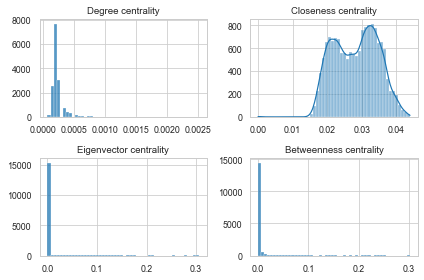

In [12]:
import seaborn as sns
def centrality_measure(G, bins: int = 50):
    sns.set_context("paper")
    sns.set_style("whitegrid")

    degree_centrality = list(nx.degree_centrality(G).values())
    closeness_centrality = list(nx.closeness_centrality(G).values())
    eigenvector_centrality = list(nx.eigenvector_centrality(G,max_iter=3000).values())
    betweenness_centrality = list(nx.betweenness_centrality(G).values())

    fig, axs = plt.subplots(2, 2)
    sns.histplot(ax=axs[0, 0], x=degree_centrality, bins=bins).set_title("Degree centrality")
    sns.histplot(ax=axs[0, 1], x=closeness_centrality, bins=bins, kde=True).set_title("Closeness centrality")
    sns.histplot(ax=axs[1, 0], x=eigenvector_centrality, bins=bins).set_title("Eigenvector centrality")
    sns.histplot(ax=axs[1, 1], x=betweenness_centrality, bins=bins).set_title("Betweenness centrality")

    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')

    fig.tight_layout()

    df = pd.DataFrame({
        "degree_centrality": degree_centrality,
        "closeness_centrality": closeness_centrality,
        "eigenvector_centrality": eigenvector_centrality,
        "betweenness_centrality": betweenness_centrality
    })

    plt.savefig(f"_img{os.sep}net_summary_{G.nodes()[random.choice(list(G.nodes()))].get('layer')}.png", dpi = 400)

    return fig, df

fig, corr_df = centrality_measure(N, bins=50)

In [13]:
corr = corr_df.corr()
corr = corr.style.background_gradient(axis=None).set_precision(3).set_properties(**{'font-size': '13pt'})
dfi.export(corr,f"_img{os.sep}corr_all.png")

C:\Users\Matte\AppData\Local\Temp\ipykernel_5856\939414987.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr = corr.style.background_gradient(axis=None).set_precision(3).set_properties(**{'font-size': '13pt'})
c:\Users\Matte\AppData\Local\Programs\Python\Python38\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


In [15]:
def degree_analysis2(G, name: str):
    fig = plt.figure("Degree of a random graph", figsize=(12, 12))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(10, 10)

    ax0 = fig.add_subplot(axgrid[5:, :5])


    degrees = [G.degree(u) for u in G]
    cdf = Cdf.from_seq(degrees, name="distribution")
    (1-cdf).plot(color="b", alpha=.4)
    
    ax0.set_title(f"CCDF (empiricaldist)")
    ax0.set_xlabel("Degree")
    ax0.set_ylabel("CCDF")
    ax0.set_xscale("log")
    ax0.set_yscale("log")

    #ax1 = fig.add_subplot(axgrid[:5, :5])
    
    #M = nx.to_scipy_sparse_matrix(G)
    #xmin = min([d[1] for d in G.degree()])
    #indegrees = M.sum(0).A[0]
    #print(type(indegrees))
    #degree = np.bincount(indegrees)
    #fit = powerlaw.Fit(np.array(degree)+1, fit_method = "KS")
    #fit.power_law.plot_pdf(color="r",linestyle="--",label="fit ccdf")
    #fit.plot_ccdf()

    #ax1.set_title(f"CCDF (powerlaw)")
    #ax1.set_xlabel("Degree")
    #ax1.set_ylabel("CCDF")
    #ax1.set_xscale("log")
    #ax1.set_yscale("log")
    

    ax2 = fig.add_subplot(axgrid[5:, 5:])
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# Nodes")

    ax3 = fig.add_subplot(axgrid[:5, :])
    B = nx.betweenness_centrality(G, normalized=True)
    betweenness_sequence = list(B.values())
    plt.hist(betweenness_sequence, bins=20)
    ax3.set_title("Betweenness distribution")
    ax3.set_xlabel("Betweenness")
    ax3.set_ylabel("# Nodes")

    fig.tight_layout()
    plt.savefig(f"_img{os.sep}ccdf_degree_{name}.png", dpi = 400)
    plt.show()

In [16]:
WS = nx.watts_strogatz_graph(n=len(N.nodes()),k = 4,p=0.5) #k = int(len(N.edges())/len(N.nodes())+0.49)
NWS = nx.newman_watts_strogatz_graph(n=len(N.nodes()),k = 3,p=0.7)

len(N.edges())

27734

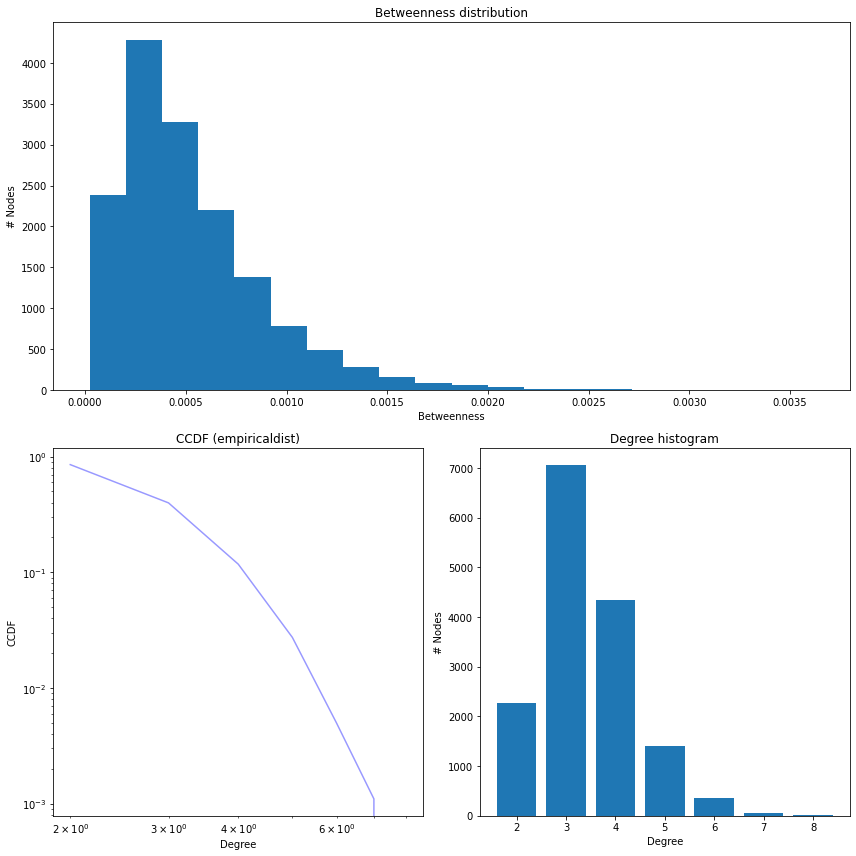

NWS edges: 30984


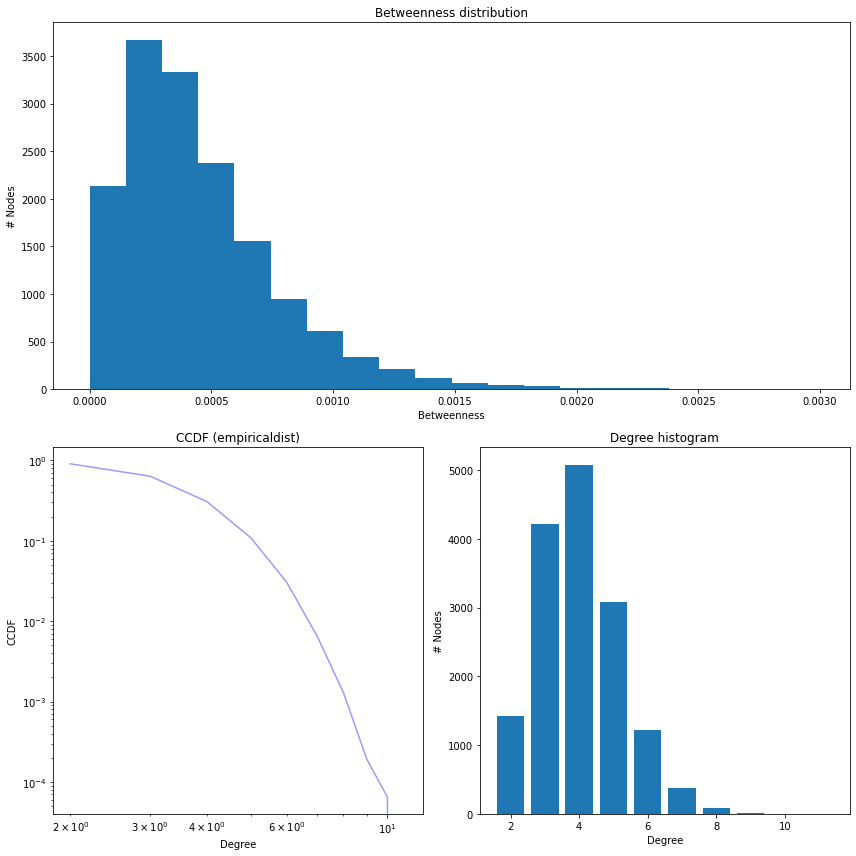

WS edges: 30984


In [17]:
degree_analysis2(NWS, name="newman_watts_strogatz")
print("NWS edges:",len(WS.edges()))
degree_analysis2(WS, name="watts_strogatz")
print("WS edges:",len(WS.edges()))

In [18]:
degree_analysis2(N, name="N_network")